# Event Study of MMP Implementation

*Author: Nicole Lin*

Summary: looking at whether the implementation of MMP penalty affects the actual discharge volumes of certain effluent parameters.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import sqlalchemy as sa
import datetime as dt

# set up connection with the database
DB_URI = os.getenv('EPA_DWH')
ENGINE = sa.create_engine(DB_URI)

# display all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# turn off warning messages
import warnings
warnings.filterwarnings('ignore')

## Prepare Data

### DMR effluent violations

In [63]:
# ICIS DMRs violations
query = f"""
SELECT
  *
FROM
  icis.dmrs
WHERE
  permit_state = 'CA'
  AND snc_type_group IN ('1', '2')
  AND effluent_violation_flag
  AND limit_value_qualifier_code IN ('<=', '<')
  AND limit_value_nmbr IS NOT NULL
  AND exceedence_pct NOT IN (99999, 2147483650) -- known data issues: https://echo.epa.gov/resources/echo-data/known-data-problems
"""

with ENGINE.begin() as conn:
    dmr_eff_viols = pd.read_sql(query, conn)
    
dmr_eff_viols.head()

,series_id,activity_id,npdes_permit_id,version_nmbr,permit_state,perm_feature_id,perm_feature_nmbr,perm_feature_type_code,limit_set_id,limit_set_designator,limit_set_schedule_id,limit_id,limit_begin_date,limit_end_date,nmbr_of_submission,nmbr_of_submission_desc,nmbr_of_report,parameter_code,parameter_desc,snc_type_group,percent_removal_flag,monitoring_location_code,stay_type_code,limit_value_id,limit_value_type_code,limit_value_nmbr,limit_unit_code,limit_unit_desc,standard_unit_code,standard_unit_desc,limit_value_standard_units,statistical_base_code,statistical_base_type_code,statistical_base_monthly_avg,limit_value_qualifier_code,limit_value_qualifier_factor,optional_monitoring_flag,limit_sample_type_code,limit_freq_of_analysis_code,stay_value_nmbr,limit_type_code,dmr_event_id,monitoring_period_end_date,monitoring_period_end_month,monitoring_period_quarter_start,monitoring_period_quarter_end,dmr_sample_type_code,dmr_freq_of_analysis_code,reported_excursion_nmbr,dmr_form_value_id,value_type_code,dmr_value_id,dmr_value_nmbr,dmr_unit_code,dmr_unit_desc,dmr_value_standard_units,dmr_value_qualifier_code,value_received_date,value_received_month,value_received_quarter_start,value_received_quarter_end,days_late,nodi_code,exceedence_pct,npdes_violation_id,violation_code,effluent_violation_flag,trc_violation_flag,rnc_detection_code,rnc_detection_date,rnc_resolution_code,rnc_resolved_flag,rnc_resolution_date,table_created_timestamp,file_timestamp
0,CA0000051_82698_1200005122_1200007936_1200042295_1200211475_MK,1200015675,CA0000051,2,CA,1200005122,01C,EXO,1200007936,S,1200015873,1200042295,2007-10-01,2012-09-07,6.0,semi-annual,6.0,82698,TCDD equivalents,2,None,1,None,1200211475,Q1,.58967,26,lb/d,01,kg/d,0.26771,MK,AVG,A,<=,1,N,GR,02/YR,None,ENF,1200194906,2009-06-30,2009-06-01 00:00:00+00:00,2009-04-01 00:00:00+00:00,2009-06-30 00:00:00+00:00,None,None,1,1204555935,Q1,1800381646,.6697,None,None,0.304044,=,2009-05-29,2009-05-01 00:00:00+00:00,2009-04-01 00:00:00+00:00,2009-06-30 00:00:00+00:00,NaN,None,14.0,1800297706,E90,True,False,None,None,None,False,None,2022-02-24 21:23:30.565170,2022-02-22
1,CA0000051_81017_1200005118_1200007926_1200042046_1200210230_MK,1200015675,CA0000051,2,CA,1200005118,001,EXO,1200007926,A,1200015853,1200042046,2007-10-01,2012-09-07,1.0,monthly,1.0,81017,Chemical Oxygen Demand [COD],1,None,1,None,1200210230,Q1,1430,26,lb/d,01,kg/d,649.22000,MK,AVG,A,<=,1,N,GR,01/30,None,ENF,1200194643,2009-08-31,2009-08-01 00:00:00+00:00,2009-07-01 00:00:00+00:00,2009-09-30 00:00:00+00:00,None,None,1,1204541030,Q1,1802771452,1481,None,None,672.373994,=,2009-09-29,2009-09-01 00:00:00+00:00,2009-07-01 00:00:00+00:00,2009-09-30 00:00:00+00:00,NaN,None,4.0,1800909009,E90,True,False,None,None,None,False,None,2022-02-24 21:23:30.565170,2022-02-22
2,CA0001139_03582_1200005170_1200008052_1200045765_1200228828_MK,1200021519,CA0001139,1,CA,1200005170,LV4,EXO,1200008052,A,1200016105,1200045765,2000-08-01,2005-05-10,1.0,monthly,1.0,03582,Oil and grease,1,None,1,None,1200228828,C2,10,19,mg/L,19,mg/L,10.00000,MK,AVG,A,<=,1,N,GR,01/30,None,ENF,1400230947,2009-08-31,2009-08-01 00:00:00+00:00,2009-07-01 00:00:00+00:00,2009-09-30 00:00:00+00:00,None,None,0,1402759273,C2,1801909364,11.8,None,None,11.800000,=,2009-09-29,2009-09-01 00:00:00+00:00,2009-07-01 00:00:00+00:00,2009-09-30 00:00:00+00:00,NaN,None,18.0,1800699887,E90,True,False,None,None,None,False,None,2022-02-24 21:23:30.565170,2022-02-22
3,CA0001180_01119_1200005204_1200008119_1200047292_1200236461_DD,1200015621,CA0001180,1,CA,1200005204,001,EXO,1200008119,S,1200016239,1200047292,2001-06-01,2006-03-10,6.0,semi-annual,6.0,01119,"Copper, total recoverable",2,None,1,None,1200236461,Q2,8.1,26,lb/d,01,kg/d,3.67740,DD,MAX,N,<=,1,N,GR,02/YR,None,ENF,1200202115,2008-12-31,2008-12-01 00:00:00+00:00,2008-10-01 00:00:00+00:00,2008-12-31 00:00:00+00:00,None,None,0,1205102201,Q2,1402122772,10.3,None,None,4.676200,=,2008-12-18,2008-12-01 00:00:00+00:00,2008-10-01 00:00:00+00:00,2008-12-31 00:00:00+00:

In [64]:
# count of all effluent violations in CA
len(dmr_eff_viols)

15016

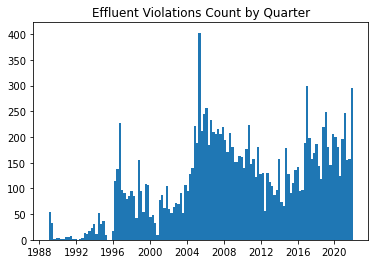

In [65]:
plt.title('Effluent Violations Count by Quarter')
plt.hist(dmr_eff_viols.monitoring_period_quarter_start, bins = len(dmr_eff_viols.monitoring_period_quarter_start.unique()))
plt.show()

In [66]:
# top pollutants from all effluent violations 
dmr_eff_viols.parameter_desc.value_counts()

Solids, total suspended                  2251
Chlorine, total residual                 1191
Copper, total recoverable                1118
BOD, 5-day, 20 deg. C                    1020
Nitrogen, ammonia total [as N]            829
                                         ... 
Phosphate, total, color method [as P]       1
Phenol                                      1
Trichlorofluoromethane                      1
Chromium, trivalent [as Cr]                 1
Sulfate                                     1
Name: parameter_desc, Length: 181, dtype: int64

### CA Data

In [67]:
# CA data: facility, enforcement and violation records
data_dir = os.path.join('~', 'sherlock_oak', 'EPA', 'Data', 'processed', 'california')
violations = pd.read_csv(os.path.join(data_dir, 'violations_2022-01-13.csv'))
facilities = pd.read_csv(os.path.join(data_dir, 'facilities_2022-01-13.csv'))
wwtp_consistent = pd.read_csv(os.path.join(data_dir, 'wwtp_consistent_2022-01-13.csv'))

In [20]:
violations.head()

,VIOLATED FACILITY REGION,FACILITY_ID,FACILITY NAME,AGENCY NAME,PLACE TYPE,PLACE SUBTYPE,FACILITY TYPE,AGENCY TYPE,COMPLEXITY,FACILITY WASTE TYPE,PROGRAM,PROGRAM CATEGORY,WDID_x,REG MEASURE TYPE,NPDES# CA#,MAJOR-MINOR,NPDES TYPE,STATUS,INDIVIDUAL/GENERAL,VIOLATION ID (VID),VIOLATION TYPE,VIOLATION SUBTYPE,VIOLATION DESCRIPTION,VIOLATION COMMENTS,CORRECTIVE ACTION,OCCURRED ON,DISCOVERY DATE,PRIORITY (Y/N),NPDES Serious (Y/N),Otherwise MMP (Y/N),EXEMPT (Y/N),Reason Exempt from MMPs,MMP TYPE,Violation Type,Priority Violation,Date Occured,Violation Description,Comments,Corrective Action,Enforcement Action ID,Enforcement Action,EA Order Number,EA Effective Date,Discovery Date,mmp_flag,enforced_flag,violation_year,enforcement_year,viol_to_enf_time,enforcement_agency,violation_category,region_group,enforced_within_period,days_to_enf,npdes_flag,wwtp_flag
0,8,259171.0,Corona WWRF #1,Corona City DWP,Utility,Wastewater Treatment Facility,Municipal/Domestic,City Agency,A,Domestic wastewater,NPDMUNILRG,NPDESWW,8 330108001,NPDES Permits,CA8000383,Major,MUN,Historical,I,181762,Effluent,CAT1,Exceeded 12-month average Sodium limit for April 2001,NaN,NaN,2001-04-30,2001-05-31,N,N,N,N,NaN,Chronic,Water Quality -> Effluent -> CAT1,N,2001-04-30,Exceeded 12-month average Sodium limit for April 2001,NaN,NaN,238075(+),Admin Civil Liability,R8-2001-0108,2001-10-19,2001-05-31,True,True,2001,2001.0,172 days 00:00:00.000000000,R8,Effluent,Region 8,True,172.0,True,True
1,8,259171.0,Corona WWRF #1,Corona City DWP,Utility,Wastewater Treatment Facility,Municipal/Domestic,City Agency,A,Domestic wastewater,NPDMUNILRG,NPDESWW,8 330108001,NPDES Permits,CA8000383,Major,MUN,Historical,I,188721,Effluent,CAT1,Exceeded 12-month average Sodium limit for February 2001,"Also, Board staff will issue a mandatory penalty complaint to address this and other violations.",NaN,2001-02-07,2001-05-08,N,N,N,N,NaN,Chronic,Water Quality -> Effluent -> CAT1,N,2001-02-07,Exceeded 12-month average Sodium limit for February 2001,"Also, Board staff will issue a mandatory penalty complaint to address this and other violations.",NaN,238075(+),Admin Civil Liability,R8-2001-0108,2001-10-19,2001-05-08,True,True,2001,2001.0,254 days 00:00:00.000000000,R8,Effluent,Region 8,True,254.0,True,True
2,8,259171.0,Corona WWRF #1,Corona City DWP,Utility,Wastewater Treatment Facility,Municipal/Domestic,City Agency,A,Domestic wastewater,NPDMUNILRG,NPDESWW,8 330108001,NPDES Permits,CA8000383,Major,MUN,Historical,I,188789,Effluent,CAT1,Exceeded 12-month average Sulfate limit for February 2001,"Also, Board staff will issue a mandatory penalty complaint to address this and other violations.",NaN,2001-02-07,2001-05-08,Y,Y,N,N,NaN,Serious,Water Quality -> Effluent -> CAT1,Y,2001-02-07,Exceeded 12-month average Sulfate limit for February 2001,"Also, Board staff will issue a mandatory penalty complaint to address this and other violations.",NaN,238075(+),Admin Civil Liability,R8-2001-0108,2001-10-19,2001-05-08,True,True,2001,2001.0,254 days 00:00:00.000000000,R8,Effluent,Region 8,True,254.0,True,True
3,4,236009.0,"Los Angeles Refinery, Carson Plant",ConocoPhillips Company Long Beach,Manufacturing,Petroleum Refinery,Industrial,Privately-Owned Business,A,Cooling water: Noncontact,NPDESWW,NPDESWW,4B192131026,NPDES Permits,CA0063185,Major,OTH,Historical,I,200268,Reporting,Late Report,June 2001 DMR submitted 17 days late.,Violation rescinded by revised NOV dated 3/25/02.,NaN,2001-07-01,2002-01-07,N,N,N,N,NaN,Non-MMP,Reporting -> Late Report,3,2001-07-01,June 2001 DMR submitted 17 days late.,Violation rescinded by revised NOV dated 3/25/02.,NaN,240323,Notice of Violation,NOV,2002-01-07,2002-01-07,False,True,2001,2002.0,190 days 00:00:00.000000000,NOV,Reporting,"Region 2, 3, 4, 5",True,190.0,True,False
4,4,236009.0,"Los Angeles Refinery, Carson Plant",ConocoPhillips Company Long Beach,Manufacturing,Petroleum Refinery,Industrial,Privately-Owned Business,A,Cooling water: Noncontact,NPDESWW,NPDESWW,4B192131026,NPDES Permi

In [21]:
facilities.head()

,WDID,start_date,end_date,Region,Program,Status,active_flag,active_days,active_years,region_group,wwtp_flag
0,1 12AP00001,2017-06-21,2018-11-30,1,NPDNONMUNIPRCS,Active,True,527.0,1.443836,Other,False
1,1 49AP00001,2017-06-21,2018-11-30,5S,NPDNONMUNIPRCS,Active,True,527.0,1.443836,"Region 2, 3, 4, 5",False
2,1000U000001,2015-08-12,2020-06-29,1,NPDNONMUNIPRCS,Historical,False,1783.0,4.884932,Other,False
3,1000U000003,2015-08-13,2020-06-29,1,NPDNONMUNIPRCS,Active,True,1782.0,4.882192,Other,False
4,1000U000008,1997-12-15,2020-06-29,1,NPDNONMUNIPRCS,Active,True,8232.0,22.553425,Other,False


In [22]:
wwtp_consistent.head()

,WDID,start_date,end_date,Region,Program,Status,active_flag,region_group,active_days,active_years,active_before_2007,active_after_2007
0,1A84006ODN,1984-01-19,2022-03-31,1,NPDMUNILRG,Active,True,Other,13951.0,38.221918,True,True
1,1B80078OMEN,1985-07-25,2020-11-30,1,NPDMUNILRG,Active,False,Other,12912.0,35.375342,True,True
2,1B82037OSON,1982-04-22,2025-09-30,1,NPDMUNILRG,Active,True,Other,15867.0,43.471233,True,True
3,1B82046OSON,1982-04-22,2021-07-31,1,NPDMUNILRG,Active,True,Other,14345.0,39.301370,True,True
4,1B82084OHUM,1982-07-22,2023-10-31,1,NPDMUNILRG,Active,True,Other,15076.0,41.304110,True,True


In [3]:
violations.PROGRAM.value_counts()

NPDMUNILRG        39674
NPDNONMUNIPRCS    31218
NPDMUNIOTH        24139
NPDESWW            7212
NPDINDLRG          4516
NPDINDSML          2245
NPDMINING          1644
DODNPDESWW         1471
MNSTW1              747
ANIWSTCOWS          667
ANIWSTOTH           533
MNSTW2              332
CONSTW              227
SWCALTRANS          226
WDRINDFP            160
WDRMUNILRG          126
INDSTW              112
WDRINDIVLRG          27
CERFILLEXC            9
WDRMINING             9
SLIC                  5
WDRNONMUNIPRCS        4
AGT                   3
UST                   1
WDRMUNIOWTS           1
WDR                   1
LNDISP                1
Name: PROGRAM, dtype: int64

In [4]:
violations[violations.PROGRAM == 'NPDMUNILRG']['PLACE SUBTYPE'].value_counts()

Wastewater Treatment Facility    38781
Pulp and Paper                     255
Collection_System                  235
Water Treatment Plant               92
Utility Structure                   11
Manufacturing NEC                   10
Metal Mining                         8
Power Plant                          8
Recycled Water Use Area              7
Domestic Site NEC                    1
Name: PLACE SUBTYPE, dtype: int64

In [5]:
39674/len(violations)

0.34392066436658053

In [68]:
# number of WWTPs have effluent violation records in CA violations data
ca_wwtp_viol_ls = list(violations[(violations.wwtp_flag) & (violations.violation_category == 'Effluent')]['NPDES# CA#'].unique())
len(ca_wwtp_viol_ls)

205

In [69]:
# proportion of effluent violations in DMRs that are from WWTP
dmr_wwtp_viols = dmr_eff_viols[dmr_eff_viols.npdes_permit_id.isin(ca_wwtp_viol_ls)]
len(dmr_wwtp_viols)/len(dmr_eff_viols)

0.679075652637187

In [70]:
# number of WWTPs have effluent violation records in DMRs data
l1 = list(dmr_wwtp_viols.npdes_permit_id.unique())
len(l1)

186

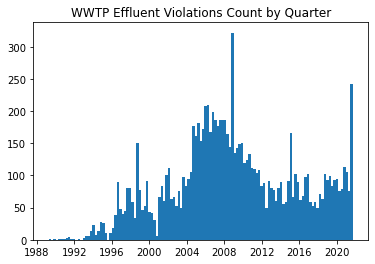

In [71]:
plt.title('WWTP Effluent Violations Count by Quarter')
plt.hist(dmr_wwtp_viols.monitoring_period_quarter_start, bins = len(dmr_wwtp_viols.monitoring_period_quarter_start.unique()))
plt.show()

In [72]:
# top pollutants from WWTP effluent violations 
dmr_wwtp_viols.parameter_desc.value_counts()

Solids, total suspended                              1504
Chlorine, total residual                              901
BOD, 5-day, 20 deg. C                                 749
BOD, carbonaceous [5 day, 20 C]                       738
Nitrogen, ammonia total [as N]                        708
                                                     ... 
Chlordane, CA Ocean Plan definition                     1
2-Methyl-4,6-dinitrophenol                              1
Polychlorinated biphenyls [PCBs], sum of Aroclors       1
N-Nitrosodi-N-propylamine                               1
Sulfate                                                 1
Name: parameter_desc, Length: 148, dtype: int64

In [73]:
dmr_wwtp_viols

,series_id,activity_id,npdes_permit_id,version_nmbr,permit_state,perm_feature_id,perm_feature_nmbr,perm_feature_type_code,limit_set_id,limit_set_designator,limit_set_schedule_id,limit_id,limit_begin_date,limit_end_date,nmbr_of_submission,nmbr_of_submission_desc,nmbr_of_report,parameter_code,parameter_desc,snc_type_group,percent_removal_flag,monitoring_location_code,stay_type_code,limit_value_id,limit_value_type_code,limit_value_nmbr,limit_unit_code,limit_unit_desc,standard_unit_code,standard_unit_desc,limit_value_standard_units,statistical_base_code,statistical_base_type_code,statistical_base_monthly_avg,limit_value_qualifier_code,limit_value_qualifier_factor,optional_monitoring_flag,limit_sample_type_code,limit_freq_of_analysis_code,stay_value_nmbr,limit_type_code,dmr_event_id,monitoring_period_end_date,monitoring_period_end_month,monitoring_period_quarter_start,monitoring_period_quarter_end,dmr_sample_type_code,dmr_freq_of_analysis_code,reported_excursion_nmbr,dmr_form_value_id,value_type_code,dmr_value_id,dmr_value_nmbr,dmr_unit_code,dmr_unit_desc,dmr_value_standard_units,dmr_value_qualifier_code,value_received_date,value_received_month,value_received_quarter_start,value_received_quarter_end,days_late,nodi_code,exceedence_pct,npdes_violation_id,violation_code,effluent_violation_flag,trc_violation_flag,rnc_detection_code,rnc_detection_date,rnc_resolution_code,rnc_resolved_flag,rnc_resolution_date,table_created_timestamp,file_timestamp
43,CA0005894_00310_1200005602_1200008795_1200060750_1200303751_DD,1200015473,CA0005894,1,CA,1200005602,001,EXO,1200008795,A,1200017591,1200060750,2004-07-01,2006-06-28,1.0,monthly,1.0,00310,"BOD, 5-day, 20 deg. C",1,None,1,None,1200303751,Q2,21630,26,lb/d,01,kg/d,9820.02000,DD,MAX,N,<=,1,N,24,01/07,None,ENF,1200226403,2008-10-31,2008-10-01 00:00:00+00:00,2008-10-01 00:00:00+00:00,2008-12-31 00:00:00+00:00,None,None,2,1206420071,Q2,1401499449,25587,None,None,11616.497902,=,2008-11-25,2008-11-01 00:00:00+00:00,2008-10-01 00:00:00+00:00,2008-12-31 00:00:00+00:00,NaN,None,18.0,1400641441,E90,True,False,None,None,None,False,None,2022-02-24 21:23:30.565170,2022-02-22
44,CA0022713_78248_1200005642_1200008866_1200061561_1200307809_DD,1200015347,CA0022713,2,CA,1200005642,001,EXO,1200008866,Q,1200017733,1200061561,2004-07-01,2009-06-22,3.0,quarterly,3.0,78248,"Cyanide, total recoverable",2,None,1,None,1200307809,C3,1,28,ug/L,19,mg/L,0.00100,DD,MAX,N,<=,1,N,24,01/90,None,ENF,1400172154,2009-09-30,2009-09-01 00:00:00+00:00,2009-07-01 00:00:00+00:00,2009-09-30 00:00:00+00:00,None,None,2,1402032810,C3,1802540634,4.6,None,None,0.004600,=,2009-10-28,2009-10-01 00:00:00+00:00,2009-10-01 00:00:00+00:00,2009-12-31 00:00:00+00:00,NaN,None,360.0,1800833145,E90,True,True,None,None,None,False,None,2022-02-24 21:23:30.565170,2022-02-22
45,CA0022713_78248_1200005642_1200008866_1200061561_1200307808_MK,1200015347,CA0022713,2,CA,1200005642,001,EXO,1200008866,Q,1200017733,1200061561,2004-07-01,2009-06-22,3.0,quarterly,3.0,78248,"Cyanide, total recoverable",2,None,1,None,1200307808,C2,.5,28,ug/L,19,mg/L,0.00050,MK,AVG,A,<=,1,N,24,01/90,None,ENF,1400172154,2009-09-30,2009-09-01 00:00:00+00:00,2009-07-01 00:00:00+00:00,2009-09-30 00:00:00+00:00,None,None,2,1402032809,C2,1802540633,4.6,None,None,0.004600,=,2009-10-28,2009-10-01 00:00:00+00:00,2009-10-01 00:00:00+00:00,2009-12-31 00:00:00+00:00,NaN,None,820.0,1800833144,E90,True,True,None,None,None,False,None,2022-02-24 21:23:30.565170,2022-02-22
46,CA0022713_01119_1200005642_1200008866_1200061558_1200307793_MK,1200015347,CA0022713,2,CA,1200005642,001,EXO,1200008866,Q,1200017733,1200061558,2004-07-01,2009-06-22,3.0,quarterly,3.0,01119,"Copper, total recoverable",2,None,1,None,1200307793,C2,2.8,28,ug/L,19,mg/L,0.00280,MK,AVG,A,<=,1,N,GR,01/90,None,ENF,1400172154,2009-09-30,2009-09-01 00:00:00+00:00,2009-07-01 00:00:00+00:00,2009-09-30 00:00:00+00:00,None,None,1,1402032804,C2,1802540628,3.1,None,None,0.003100,=,2009-10-28,2009-10-01 00:00:00+00:00,2009-10-01 00:00:00+00:00,2009-

## Sample Time Series

In [6]:
# flag facilities with decreasing count of effluent MMP violations
wwtp_mmp_viol = violations[(violations.mmp_flag) & (violations.wwtp_flag) & (violations.violation_category == 'Effluent')]
wwtp_mmp_viol_count = wwtp_mmp_viol.groupby(['WDID_x', 'NPDES# CA#', 'violation_year'])['VIOLATION ID (VID)'].count().to_frame().reset_index()
wwtp_mmp_viol_count = wwtp_mmp_viol_count.rename(columns = {'VIOLATION ID (VID)': 'violation_count'})
wwtp_mmp_viol_count = wwtp_mmp_viol_count.sort_values(by = ['WDID_x', 'violation_year'])
wwtp_mmp_viol_count['diff'] = wwtp_mmp_viol_count.violation_count.diff()
mask = wwtp_mmp_viol_count.WDID_x != wwtp_mmp_viol_count.WDID_x.shift(1)
wwtp_mmp_viol_count['diff'][mask] = np.nan
wwtp_mmp_viol_count['decrease_violation'] = wwtp_mmp_viol_count['diff'] < 0
wwtp_mmp_viol_count[(wwtp_mmp_viol_count.decrease_violation) & (wwtp_mmp_viol_count.violation_year == 2009)]

,WDID_x,NPDES# CA#,violation_year,violation_count,diff,decrease_violation
199,2 215022001,CA0037958,2009,2,-11.0,True
253,2 417022002,CA0038776,2009,3,-11.0,True
344,2 494009001,CA0037800,2009,3,-7.0,True
350,3 270101001,CA0047996,2009,1,-1.0,True
421,3 400108001,CA0047856,2009,7,-18.0,True
470,3 420108001,CA0048143,2009,4,-8.0,True
501,4A560100001,CA0053597,2009,19,-10.0,True
552,4A560108001,CA0054224,2009,8,-7.0,True
680,5A310100001,CA0077712,2009,5,-4.0,True
746,5A450103001,CA0079731,2009,3,-1.0,True


In [14]:
# ICIS DMRs: discharge volumes 
sample_id = 'CA0037800'
query = f"""
SELECT
  *
FROM
  icis.dmrs
WHERE
  npdes_permit_id = '{sample_id}'
  and limit_value_standard_units is not null
  and limit_value_qualifier_code in ('<', '<=')
  and snc_type_group in ('1', '2')
"""


with ENGINE.begin() as conn:
    dmrs = pd.read_sql(query, conn)
    
dmrs.head()

,series_id,activity_id,npdes_permit_id,version_nmbr,permit_state,perm_feature_id,perm_feature_nmbr,perm_feature_type_code,limit_set_id,limit_set_designator,limit_set_schedule_id,limit_id,limit_begin_date,limit_end_date,nmbr_of_submission,nmbr_of_submission_desc,nmbr_of_report,parameter_code,parameter_desc,snc_type_group,percent_removal_flag,monitoring_location_code,stay_type_code,limit_value_id,limit_value_type_code,limit_value_nmbr,limit_unit_code,limit_unit_desc,standard_unit_code,standard_unit_desc,limit_value_standard_units,statistical_base_code,statistical_base_type_code,statistical_base_monthly_avg,limit_value_qualifier_code,limit_value_qualifier_factor,optional_monitoring_flag,limit_sample_type_code,limit_freq_of_analysis_code,stay_value_nmbr,limit_type_code,dmr_event_id,monitoring_period_end_date,monitoring_period_end_month,monitoring_period_quarter_start,monitoring_period_quarter_end,dmr_sample_type_code,dmr_freq_of_analysis_code,reported_excursion_nmbr,dmr_form_value_id,value_type_code,dmr_value_id,dmr_value_nmbr,dmr_unit_code,dmr_unit_desc,dmr_value_standard_units,dmr_value_qualifier_code,value_received_date,value_received_month,value_received_quarter_start,value_received_quarter_end,days_late,nodi_code,exceedence_pct,npdes_violation_id,violation_code,effluent_violation_flag,trc_violation_flag,rnc_detection_code,rnc_detection_date,rnc_resolution_code,rnc_resolved_flag,rnc_resolution_date,table_created_timestamp,file_timestamp
0,CA0037800_50060_1200005855_1200009245_1200070590_1200352954_IA,1200022171,CA0037800,1,CA,1200005855,001,EXO,1200009245,A,1200018491,1200070590,2002-04-01,2007-02-28,1.0,monthly,1.0,50060,"Chlorine, total residual",2,None,1,None,1200352954,C3,0,19,mg/L,19,mg/L,0.000000,IA,MAX,N,<=,1,N,24,99/99,None,ENF,1200244046,2008-10-31,2008-10-01 00:00:00+00:00,2008-10-01 00:00:00+00:00,2008-12-31 00:00:00+00:00,None,None,None,1207696344,C3,1401513421,None,None,None,NaN,None,2008-11-26,2008-11-01 00:00:00+00:00,2008-10-01 00:00:00+00:00,2008-12-31 00:00:00+00:00,NaN,C,NaN,None,None,False,False,None,None,None,False,None,2021-10-25 23:56:52.091473,2021-10-22
1,CA0037800_03582_1200005855_1200009245_1200070588_1200352944_DD,1200022171,CA0037800,1,CA,1200005855,001,EXO,1200009245,A,1200018491,1200070588,2002-04-01,2007-02-28,1.0,monthly,1.0,03582,Oil and grease,1,None,1,None,1200352944,C3,20,19,mg/L,19,mg/L,20.000000,DD,MAX,N,<=,1,N,GR,01/30,None,ENF,1200244046,2008-10-31,2008-10-01 00:00:00+00:00,2008-10-01 00:00:00+00:00,2008-12-31 00:00:00+00:00,None,None,None,1207695464,C3,1401513417,None,None,None,NaN,None,2008-11-26,2008-11-01 00:00:00+00:00,2008-10-01 00:00:00+00:00,2008-12-31 00:00:00+00:00,NaN,C,NaN,None,None,False,False,None,None,None,False,None,2021-10-25 23:56:52.091473,2021-10-22
2,CA0037800_71901_1200005855_1200009245_1200070591_1200352959_DD,1200022171,CA0037800,1,CA,1200005855,001,EXO,1200009245,A,1200018491,1200070591,2002-04-01,2007-02-28,1.0,monthly,1.0,71901,"Mercury, total recoverable",2,None,1,None,1200352959,C3,1,28,ug/L,19,mg/L,0.001000,DD,MAX,N,<=,1,N,GR,01/30,None,ENF,1200244046,2008-10-31,2008-10-01 00:00:00+00:00,2008-10-01 00:00:00+00:00,2008-12-31 00:00:00+00:00,None,None,None,1207696784,C3,1401513423,None,None,None,NaN,None,2008-11-26,2008-11-01 00:00:00+00:00,2008-10-01 00:00:00+00:00,2008-12-31 00:00:00+00:00,NaN,C,NaN,None,None,False,False,None,None,None,False,None,2021-10-25 23:56:52.091473,2021-10-22
3,CA0037800_71901_1200005855_1200009245_1200070591_1200352956_MB,1200022171,CA0037800,1,CA,1200005855,001,EXO,1200009245,A,1200018491,1200070591,2002-04-01,2007-02-28,1.0,monthly,1.0,71901,"Mercury, total recoverable",2,None,1,None,1200352956,Q2,.047,1W,kg/mo,01,kg/d,0.001551,MB,MAX,N,<=,1,N,GR,01/30,None,ENF,1200244046,2008-10-31,2008-10-01 00:00:00+00:00,2008-10-01 00:00:00+00:00,2008-12-31 00:00:00+00:00,None,None,None,1207696781,Q2,1401513424,None,None,None,NaN,None,2008-11-26,2008-11-01 00:00:00+00:00,2008-10-01 00:00:00+00:00,2008-12-31 00:00:00+00:00,NaN,C,NaN,None,None,F

In [15]:
len(dmrs)

5224

In [16]:
len(dmrs.series_id.unique())

139

In [17]:
len(dmrs.parameter_desc.unique())

26

In [18]:
dmrs.groupby(['parameter_code', 'parameter_desc'])['effluent_violation_flag'].sum().sort_values(ascending = False)

parameter_code  parameter_desc                                   
50060           Chlorine, total residual                             12.0
00720           Cyanide, total [as CN]                               10.0
03582           Oil and grease                                        5.0
82698           TCDD equivalents                                      3.0
01094           Zinc, total recoverable                               2.0
01119           Copper, total recoverable                             2.0
00530           Solids, total suspended                               1.0
01074           Nickel, total recoverable                             1.0
34230           Benzo[b]fluoranthene                                  0.0
00545           Solids, settleable                                    0.0
00610           Nitrogen, ammonia total [as N]                        0.0
01114           Lead, total recoverable                               0.0
03824           Tributyltin                   

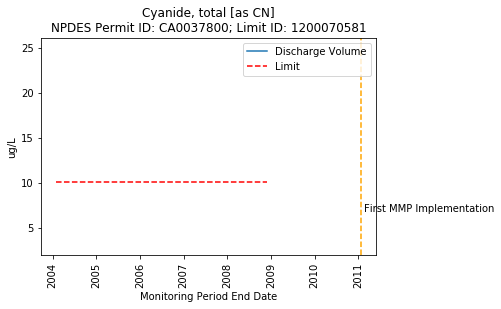

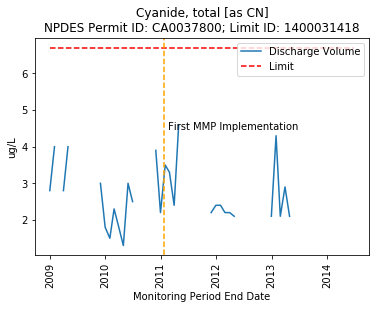

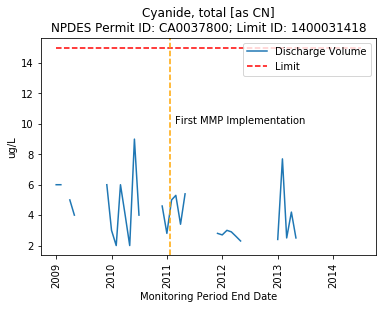

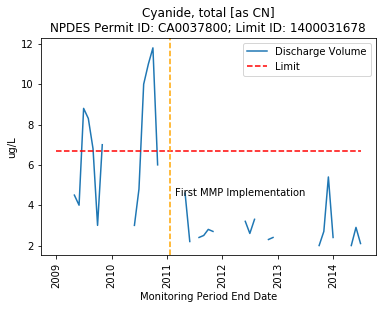

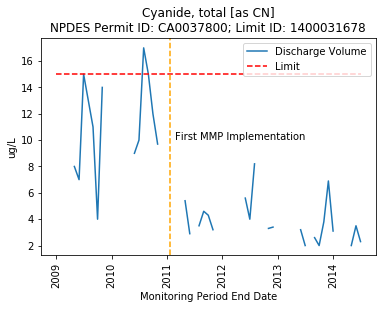

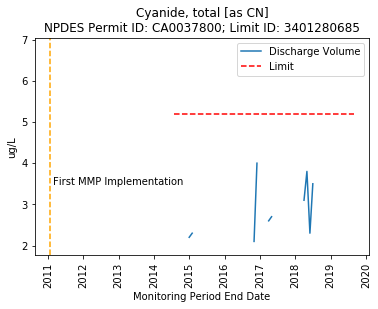

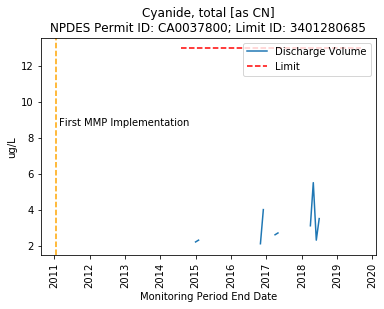

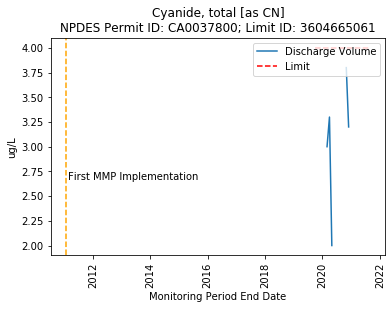

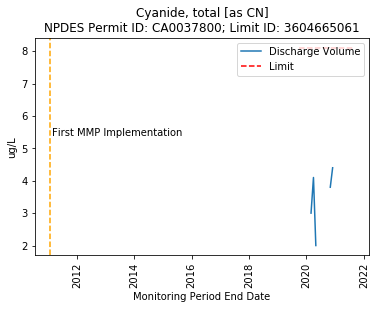

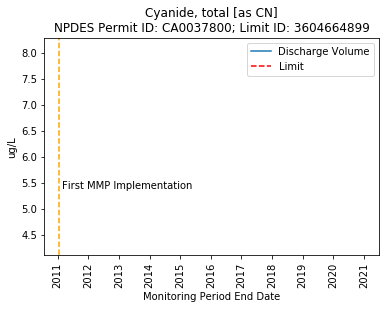

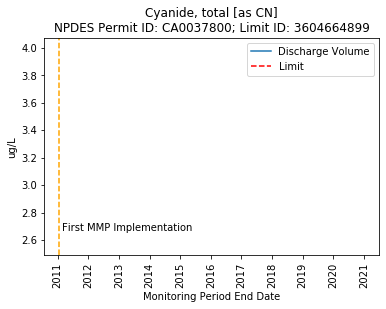

In [19]:
# dmr volume time series
sample_parameter_code = '00720'
sample_parameter_desc = 'Cyanide'
viol_df = dmrs[dmrs.parameter_code == sample_parameter_code]
viol_df.monitoring_period_end_date = pd.to_datetime(viol_df.monitoring_period_end_date)

# enforcement actions: when was the first time that MMP was first implemented for the parameter?
enf_df = wwtp_mmp_viol[(wwtp_mmp_viol['NPDES# CA#'] == sample_id) & (wwtp_mmp_viol.enforced_flag) & (wwtp_mmp_viol['Violation Description'].str.contains(sample_parameter_desc, case = False))]
first_enf_date = pd.to_datetime(enf_df['EA Effective Date'].min())

series = viol_df.series_id.unique()
for s in series:
    sub_df = viol_df[viol_df.series_id == s]
    sub_df = sub_df.sort_values('monitoring_period_end_date')
    plt.title(f'{sub_df.parameter_desc.unique()[0]}\nNPDES Permit ID: {sub_df.npdes_permit_id.unique()[0]}; Limit ID: {sub_df.limit_id.unique()[0]}')
    plt.plot(sub_df.monitoring_period_end_date, pd.to_numeric(sub_df.dmr_value_nmbr))
    plt.plot(sub_df.monitoring_period_end_date, pd.to_numeric(sub_df.limit_value_nmbr), 'r--')
    plt.axvline(x = first_enf_date, color = 'orange', linestyle = '--')
    plt.legend(['Discharge Volume', 'Limit'], loc = 'upper right')
    plt.xticks(rotation = 90)
    plt.xlabel('Monitoring Period End Date')
    plt.ylabel(sub_df.limit_unit_desc.unique()[0])
    plt.annotate('First MMP Implementation', (first_enf_date + pd.DateOffset(30), pd.to_numeric(sub_df.limit_value_nmbr).tolist()[0]/1.5))
    plt.show()

Potential demonstration pairs: 
1. CA0038776: 00530
2. CA0037800: 00720
3. CA0053597: 00640
4. CA0079731: 00530, 00310
5. CA0082660: 32105

In [20]:
wwtp_mmp_viol[(wwtp_mmp_viol['NPDES# CA#'] == sample_id) & (wwtp_mmp_viol.enforced_flag)].sort_values(['EA Effective Date'])

,VIOLATED FACILITY REGION,FACILITY_ID,FACILITY NAME,AGENCY NAME,PLACE TYPE,PLACE SUBTYPE,FACILITY TYPE,AGENCY TYPE,COMPLEXITY,FACILITY WASTE TYPE,PROGRAM,PROGRAM CATEGORY,WDID_x,REG MEASURE TYPE,NPDES# CA#,MAJOR-MINOR,NPDES TYPE,STATUS,INDIVIDUAL/GENERAL,VIOLATION ID (VID),VIOLATION TYPE,VIOLATION SUBTYPE,VIOLATION DESCRIPTION,VIOLATION COMMENTS,CORRECTIVE ACTION,OCCURRED ON,DISCOVERY DATE,PRIORITY (Y/N),NPDES Serious (Y/N),Otherwise MMP (Y/N),EXEMPT (Y/N),Reason Exempt from MMPs,MMP TYPE,Violation Type,Priority Violation,Date Occured,Violation Description,Comments,Corrective Action,Enforcement Action ID,Enforcement Action,EA Order Number,EA Effective Date,Discovery Date,mmp_flag,enforced_flag,violation_year,enforcement_year,viol_to_enf_time,enforcement_agency,violation_category,region_group,enforced_within_period,days_to_enf,npdes_flag,wwtp_flag
28802,2,257754.0,Sonoma Valley County SD WWTP,Sonoma County Water Agency (SCWA),Utility,Wastewater Treatment Facility,Municipal/Domestic,County Agency,A,Domestic wastewater,NPDMUNILRG,NPDESWW,2 494009001,NPDES Permits,CA0037800,Major,MUN,Historical,I,139620,Effluent,CAT2,Zinc exceeded daily average limit of 58 mg/l with 70 mg/l,NaN,NaN,2000-01-10,2000-03-29,Y,Y,N,N,NaN,Serious,Water Quality -> Effluent -> CAT2,Y,2000-01-10,Zinc exceeded daily average limit of 58 mg/l with 70 mg/l,NaN,NaN,235611,Admin Civil Liability,R2-2001-0020A,2001-05-23,2000-03-29,True,True,2000,2001.0,499 days 00:00:00.000000000,R2,Effluent,"Region 2, 3, 4, 5",True,499.0,True,True
28838,2,257754.0,Sonoma Valley County SD WWTP,Sonoma County Water Agency (SCWA),Utility,Wastewater Treatment Facility,Municipal/Domestic,County Agency,A,Domestic wastewater,NPDMUNILRG,NPDESWW,2 494009001,NPDES Permits,CA0037800,Major,MUN,Historical,I,197261,Effluent,CAT1,"ph eff grab minimum unit, permit limit is 6.5 min., reported value is 6.4.",NaN,NaN,2000-01-31,NaN,N,N,Y,N,NaN,Chronic,Water Quality -> Effluent -> CAT1,N,2000-01-31,"ph eff grab minimum unit, permit limit is 6.5 min., reported value is 6.4.",NaN,NaN,235611,Admin Civil Liability,R2-2001-0020A,2001-05-23,NaN,True,True,2000,2001.0,478 days 00:00:00.000000000,R2,Effluent,"Region 2, 3, 4, 5",True,478.0,True,True
28830,2,257754.0,Sonoma Valley County SD WWTP,Sonoma County Water Agency (SCWA),Utility,Wastewater Treatment Facility,Municipal/Domestic,County Agency,A,Domestic wastewater,NPDMUNILRG,NPDESWW,2 494009001,NPDES Permits,CA0037800,Major,MUN,Historical,I,141027,Effluent,CAT2,Zinc daily avg 64 mg/l vs. 58,NaN,NaN,2000-12-11,2001-01-24,N,N,Y,N,NaN,Chronic,Water Quality -> Effluent -> CAT2,N,2000-12-11,Zinc daily avg 64 mg/l vs. 58,NaN,NaN,235611,Admin Civil Liability,R2-2001-0020A,2001-05-23,2001-01-24,True,True,2000,2001.0,163 days 00:00:00.000000000,R2,Effluent,"Region 2, 3, 4, 5",True,163.0,True,True
28829,2,257754.0,Sonoma Valley County SD WWTP,Sonoma County Water Agency (SCWA),Utility,Wastewater Treatment Facility,Municipal/Domestic,County Agency,A,Domestic wastewater,NPDMUNILRG,NPDESWW,2 494009001,NPDES Permits,CA0037800,Major,MUN,Historical,I,141025,Effluent,CAT2,Zinc daily max 62 mg/l vs. 58,NaN,NaN,2000-12-04,2001-01-24,N,N,Y,N,NaN,Chronic,Water Quality -> Effluent -> CAT2,N,2000-12-04,Zinc daily max 62 mg/l vs. 58,NaN,NaN,235611,Admin Civil Liability,R2-2001-0020A,2001-05-23,2001-01-24,True,True,2000,2001.0,170 days 00:00:00.000000000,R2,Effluent,"Region 2, 3, 4, 5",True,170.0,True,True
28828,2,257754.0,Sonoma Valley County SD WWTP,Sonoma County Water Agency (SCWA),Utility,Wastewater Treatment Facility,Municipal/Domestic,County Agency,A,Domestic wastewater,NPDMUNILRG,NPDESWW,2 494009001,NPDES Permits,CA0037800,Major,MUN,Historical,I,141023,Effluent,CAT2,Zinc daily average 76 mg/l,NaN,NaN,2000-11-20,2000-11-20,Y,Y,Y,N,NaN,Serious,Water Quality -> Effluent -> CAT2,Y,2000-11-20,Zinc daily average 76 mg/l,NaN,NaN,235611,Admin Civil Liability,R2-2001-0020A,2001-05-23,2000-11-20,True,True,2000,2001.0,184 days 00:00:00.000000000,R2,Effluent,"Region 2, 3, 4, 5",True,18

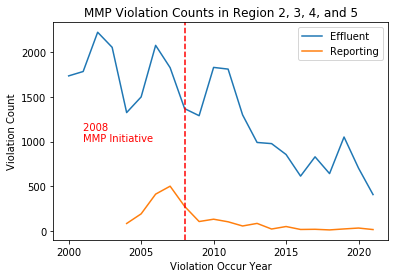

In [21]:
df = violations[(violations.region_group == 'Region 2, 3, 4, 5') & (violations.mmp_flag)]
plot_df = df.groupby(['violation_year', 'violation_category'])['VIOLATION ID (VID)'].count().to_frame().reset_index()
plot_df = plot_df.rename(columns = {'VIOLATION ID (VID)': 'violation_count'})

# plot violation count across time
plt.title('MMP Violation Counts in Region 2, 3, 4, and 5')
plt.plot(plot_df[plot_df.violation_category == 'Effluent'].violation_year, plot_df[plot_df.violation_category == 'Effluent'].violation_count)
plt.plot(plot_df[plot_df.violation_category == 'Reporting'].violation_year, plot_df[plot_df.violation_category == 'Reporting'].violation_count)
plt.legend(['Effluent', 'Reporting'])
plt.xlabel('Violation Occur Year')
plt.ylabel('Violation Count')
plt.axvline(x = 2008,color = 'red',linestyle = '--')
plt.annotate('2008 \nMMP Initiative', (2001, 1000), color = 'red')
plt.show()

In [258]:
new = """
"ACTIVITY_ID","EXTERNAL_PERMIT_NMBR","VERSION_NMBR","PERM_FEATURE_ID","PERM_FEATURE_NMBR","PERM_FEATURE_TYPE_CODE","LIMIT_SET_ID","LIMIT_SET_DESIGNATOR","LIMIT_SET_SCHEDULE_ID","LIMIT_ID","LIMIT_BEGIN_DATE","LIMIT_END_DATE","NMBR_OF_SUBMISSION","NMBR_OF_REPORT","PARAMETER_CODE","PARAMETER_DESC","MONITORING_LOCATION_CODE","STAY_TYPE_CODE","LIMIT_VALUE_ID","LIMIT_VALUE_TYPE_CODE","LIMIT_VALUE_NMBR","LIMIT_UNIT_CODE","LIMIT_UNIT_DESC","STANDARD_UNIT_CODE","STANDARD_UNIT_DESC","LIMIT_VALUE_STANDARD_UNITS","STATISTICAL_BASE_CODE","STATISTICAL_BASE_TYPE_CODE","LIMIT_VALUE_QUALIFIER_CODE","OPTIONAL_MONITORING_FLAG","LIMIT_SAMPLE_TYPE_CODE","LIMIT_FREQ_OF_ANALYSIS_CODE","STAY_VALUE_NMBR","LIMIT_TYPE_CODE","DMR_EVENT_ID","MONITORING_PERIOD_END_DATE","DMR_SAMPLE_TYPE_CODE","DMR_FREQ_OF_ANALYSIS_CODE","REPORTED_EXCURSION_NMBR","DMR_FORM_VALUE_ID","VALUE_TYPE_CODE","DMR_VALUE_ID","DMR_VALUE_NMBR","DMR_UNIT_CODE","DMR_UNIT_DESC","DMR_VALUE_STANDARD_UNITS","DMR_VALUE_QUALIFIER_CODE","VALUE_RECEIVED_DATE","DAYS_LATE","NODI_CODE","EXCEEDENCE_PCT","NPDES_VIOLATION_ID","VIOLATION_CODE","RNC_DETECTION_CODE","RNC_DETECTION_DATE","RNC_RESOLUTION_CODE","RNC_RESOLUTION_DATE"
"""

old = """
"ACTIVITY_ID","EXTERNAL_PERMIT_NMBR","VERSION_NMBR","PERM_FEATURE_ID","PERM_FEATURE_NMBR","PERM_FEATURE_TYPE_CODE","LIMIT_SET_ID","LIMIT_SET_DESIGNATOR","LIMIT_SET_SCHEDULE_ID","LIMIT_ID","LIMIT_BEGIN_DATE","LIMIT_END_DATE","NMBR_OF_SUBMISSION","NMBR_OF_REPORT","PARAMETER_CODE","PARAMETER_DESC","MONITORING_LOCATION_CODE","STAY_TYPE_CODE","LIMIT_VALUE_ID","LIMIT_VALUE_TYPE_CODE","LIMIT_VALUE_NMBR","LIMIT_UNIT_CODE","LIMIT_UNIT_DESC","STANDARD_UNIT_CODE","STANDARD_UNIT_DESC","LIMIT_VALUE_STANDARD_UNITS","STATISTICAL_BASE_CODE","STATISTICAL_BASE_TYPE_CODE","LIMIT_VALUE_QUALIFIER_CODE","OPTIONAL_MONITORING_FLAG","LIMIT_SAMPLE_TYPE_CODE","LIMIT_FREQ_OF_ANALYSIS_CODE","STAY_VALUE_NMBR","LIMIT_TYPE_CODE","DMR_EVENT_ID","MONITORING_PERIOD_END_DATE","DMR_SAMPLE_TYPE_CODE","DMR_FREQ_OF_ANALYSIS_CODE","REPORTED_EXCURSION_NMBR","DMR_FORM_VALUE_ID","VALUE_TYPE_CODE","DMR_VALUE_ID","DMR_VALUE_NMBR","DMR_UNIT_CODE","DMR_UNIT_DESC","DMR_VALUE_STANDARD_UNITS","DMR_VALUE_QUALIFIER_CODE","VALUE_RECEIVED_DATE","DAYS_LATE","NODI_CODE","EXCEEDENCE_PCT","NPDES_VIOLATION_ID","VIOLATION_CODE","RNC_DETECTION_CODE","RNC_DETECTION_DATE","RNC_RESOLUTION_CODE","RNC_RESOLUTION_DATE"
"""

new == old

True

## Infer accurate date when the letters were sent out in the 2008 initiative

In a meeting with Erin on Jan 25, 2022. She clarified that the letters were sent out to all facilities with backlogged MMP violations in Region 2, 3, 4, and 5 in the same time with a mail merge. We want to infer the actual date when the letters were sent out for event study.

5S    2908
4     1717
1      322
2      173
7      171
8      132
9      121
6B      96
5F      72
5R      71
3       35
Name: VIOLATED FACILITY REGION, dtype: int64


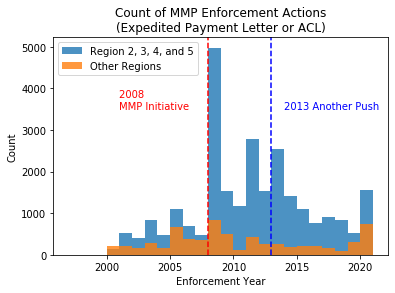

In [25]:
df = violations[(violations.mmp_flag) & (violations.enforced_flag) & (violations['Enforcement Action'].isin(['Admin Civil Liability', 'Expedited Payment Letter']))]
print(df[df.enforcement_year == 2008]['VIOLATED FACILITY REGION'].value_counts())

# count of enforcement actions for mmp violations over time in region 2, 3, 4, and 5
plt.title('Count of MMP Enforcement Actions\n(Expedited Payment Letter or ACL)')
plt.hist(df[df.region_group == 'Region 2, 3, 4, 5'].enforcement_year, bins = len(df.enforcement_year.unique()), alpha = 0.8)
plt.hist(df[df.region_group != 'Region 2, 3, 4, 5'].enforcement_year, bins = len(df.enforcement_year.unique())-3, alpha = 0.8)
plt.legend(['Region 2, 3, 4, and 5', 'Other Regions'])
plt.axvline(x = 2008,color = 'red',linestyle = '--')
plt.annotate('2008 \nMMP Initiative', (2001, 3500), color = 'red')
plt.axvline(x = 2013,color = 'blue',linestyle = '--')
plt.annotate('2013 Another Push', (2014, 3500), color = 'blue')
plt.xlabel('Enforcement Year')
plt.ylabel('Count')
plt.show()

In [99]:
# Identify letters from the 2008 MMP initiative
mmp_init = violations[(violations.mmp_flag) & (violations.enforced_flag) & (violations.enforcement_year.isin([2008]))]
mmp_init['Enforcement Action'].value_counts()

Admin Civil Liability           5817
Time Schedule Order                4
Formal Refer to Attorney Gen       4
Staff Enforcement Letter           1
Expedited Payment Letter           1
Name: Enforcement Action, dtype: int64

In [106]:
5817/len(mmp_init)

0.9982838510382701

In [100]:
mmp_init.groupby(['VIOLATED FACILITY REGION', 'enforcement_agency'])['VIOLATION ID (VID)'].count()

VIOLATED FACILITY REGION  enforcement_agency
1                         R1                     322
2                         R2                      67
                          SWB                    106
3                         R3                       4
                          SWB                     31
4                         R4                    1692
                          SWB                     25
5F                        R5                      72
5R                        R5                      71
5S                        R5                    2912
6B                        R6V                     96
7                         R7                     171
8                         R8                     132
9                         R9                     121
Name: VIOLATION ID (VID), dtype: int64

In [101]:
mmp_init[mmp_init.enforcement_agency == 'SWB']['EA Effective Date'].value_counts()[:10]

2008-11-19    110
2008-07-24     21
2008-12-09     13
2008-12-10     12
2008-11-20      5
2008-07-01      1
Name: EA Effective Date, dtype: int64

In [105]:
def swb_letters_count(letter_date):
    df = mmp_init[(mmp_init.enforcement_agency == 'SWB') & (mmp_init['EA Effective Date'] == letter_date)]
    print('==== ', letter_date, ":")
    print(df['VIOLATED FACILITY REGION'].value_counts())
    print(len(df['WDID_x'].unique()), ' facilities')

swb_letters_count('2008-11-19')
swb_letters_count('2008-07-24')
swb_letters_count('2008-12-09')

====  2008-11-19 :
2    85
3    25
Name: VIOLATED FACILITY REGION, dtype: int64
31  facilities
====  2008-07-24 :
2    21
Name: VIOLATED FACILITY REGION, dtype: int64
2  facilities
====  2008-12-09 :
4    13
Name: VIOLATED FACILITY REGION, dtype: int64
4  facilities


(array([733224., 733255., 733286., 733316., 733347., 733377.]),
 <a list of 6 Text xticklabel objects>)

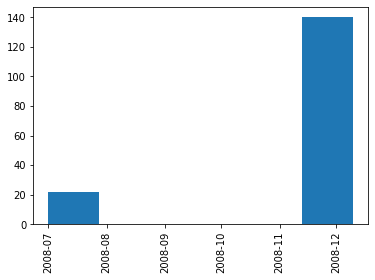

In [103]:
df = mmp_init[mmp_init.enforcement_agency == 'SWB']
df['EA Effective Date'] = pd.to_datetime(df['EA Effective Date'])
plt.hist(df['EA Effective Date'], bins = len(df['EA Effective Date'].unique()))
plt.xticks(rotation = 90)

In [90]:
len(df['EA Effective Date'].unique())

12

In [85]:
mmp_init['EA Effective Date'].value_counts()[:10]

2008-09-18    707
2008-05-05    579
2008-09-12    572
2008-09-05    315
2008-09-15    300
2008-11-19    267
2008-12-22    225
2008-11-17    189
2009-04-23    175
2009-07-15    168
Name: EA Effective Date, dtype: int64

In [67]:
mmp_init['EA Order Number'].value_counts()

R5-2008-0560       707
R5-2008-0561       568
R5-2008-0525       358
R4-2008-0036       315
R4-2008-0046-M     270
                  ... 
R4-2008-0107-M       1
R4-2009-0055-M       1
R5-2008-0571         1
SWB-2008-2-0027      1
R5-2010-0519         1
Name: EA Order Number, Length: 372, dtype: int64

In [68]:
mmp_init[mmp_init['EA Order Number'] == 'R5-2008-0560']['WDID_x'].value_counts()

5A060103001    707
Name: WDID_x, dtype: int64

In [45]:
violations[(violations.violation_year <= 2007) & (violations.mmp_flag)]

,VIOLATED FACILITY REGION,FACILITY_ID,FACILITY NAME,AGENCY NAME,PLACE TYPE,PLACE SUBTYPE,FACILITY TYPE,AGENCY TYPE,COMPLEXITY,FACILITY WASTE TYPE,PROGRAM,PROGRAM CATEGORY,WDID_x,REG MEASURE TYPE,NPDES# CA#,MAJOR-MINOR,NPDES TYPE,STATUS,INDIVIDUAL/GENERAL,VIOLATION ID (VID),VIOLATION TYPE,VIOLATION SUBTYPE,VIOLATION DESCRIPTION,VIOLATION COMMENTS,CORRECTIVE ACTION,OCCURRED ON,DISCOVERY DATE,PRIORITY (Y/N),NPDES Serious (Y/N),Otherwise MMP (Y/N),EXEMPT (Y/N),Reason Exempt from MMPs,MMP TYPE,Violation Type,Priority Violation,Date Occured,Violation Description,Comments,Corrective Action,Enforcement Action ID,Enforcement Action,EA Order Number,EA Effective Date,Discovery Date,mmp_flag,enforced_flag,violation_year,enforcement_year,viol_to_enf_time,enforcement_agency,violation_category,region_group,enforced_within_period,days_to_enf,npdes_flag,wwtp_flag
0,8,259171.0,Corona WWRF #1,Corona City DWP,Utility,Wastewater Treatment Facility,Municipal/Domestic,City Agency,A,Domestic wastewater,NPDMUNILRG,NPDESWW,8 330108001,NPDES Permits,CA8000383,Major,MUN,Historical,I,181762,Effluent,CAT1,Exceeded 12-month average Sodium limit for April 2001,NaN,NaN,2001-04-30,2001-05-31,N,N,N,N,NaN,Chronic,Water Quality -> Effluent -> CAT1,N,2001-04-30,Exceeded 12-month average Sodium limit for April 2001,NaN,NaN,238075(+),Admin Civil Liability,R8-2001-0108,2001-10-19,2001-05-31,True,True,2001,2001.0,172 days 00:00:00.000000000,R8,Effluent,Region 8,True,172.0,True,True
1,8,259171.0,Corona WWRF #1,Corona City DWP,Utility,Wastewater Treatment Facility,Municipal/Domestic,City Agency,A,Domestic wastewater,NPDMUNILRG,NPDESWW,8 330108001,NPDES Permits,CA8000383,Major,MUN,Historical,I,188721,Effluent,CAT1,Exceeded 12-month average Sodium limit for February 2001,"Also, Board staff will issue a mandatory penalty complaint to address this and other violations.",NaN,2001-02-07,2001-05-08,N,N,N,N,NaN,Chronic,Water Quality -> Effluent -> CAT1,N,2001-02-07,Exceeded 12-month average Sodium limit for February 2001,"Also, Board staff will issue a mandatory penalty complaint to address this and other violations.",NaN,238075(+),Admin Civil Liability,R8-2001-0108,2001-10-19,2001-05-08,True,True,2001,2001.0,254 days 00:00:00.000000000,R8,Effluent,Region 8,True,254.0,True,True
2,8,259171.0,Corona WWRF #1,Corona City DWP,Utility,Wastewater Treatment Facility,Municipal/Domestic,City Agency,A,Domestic wastewater,NPDMUNILRG,NPDESWW,8 330108001,NPDES Permits,CA8000383,Major,MUN,Historical,I,188789,Effluent,CAT1,Exceeded 12-month average Sulfate limit for February 2001,"Also, Board staff will issue a mandatory penalty complaint to address this and other violations.",NaN,2001-02-07,2001-05-08,Y,Y,N,N,NaN,Serious,Water Quality -> Effluent -> CAT1,Y,2001-02-07,Exceeded 12-month average Sulfate limit for February 2001,"Also, Board staff will issue a mandatory penalty complaint to address this and other violations.",NaN,238075(+),Admin Civil Liability,R8-2001-0108,2001-10-19,2001-05-08,True,True,2001,2001.0,254 days 00:00:00.000000000,R8,Effluent,Region 8,True,254.0,True,True
13,8,259171.0,Corona WWRF #1,Corona City DWP,Utility,Wastewater Treatment Facility,Municipal/Domestic,City Agency,A,Domestic wastewater,NPDMUNILRG,NPDESWW,8 330108001,NPDES Permits,CA8000383,Major,MUN,Historical,I,188790,Effluent,CAT1,Exceeded 12-month average TDS limit for February 2001,"Also, Board staff will issue a mandatory penalty complaint to address this and other violations.",NaN,2001-02-07,2001-05-08,N,N,N,N,NaN,Chronic,Water Quality -> Effluent -> CAT1,N,2001-02-07,Exceeded 12-month average TDS limit for February 2001,"Also, Board staff will issue a mandatory penalty complaint to address this and other violations.",NaN,238075(+),Admin Civil Liability,R8-2001-0108,2001-10-19,2001-05-08,True,True,2001,2001.0,254 days 00:00:00.000000000,R8,Effluent,Region 8,True,254.0,True,True
14,8,259171.0,Corona WWRF #1,Corona City DWP,Utility,Wastewater Treatment Facility,Municipal/Domestic,City Agency,A,Domestic wastewa

In [110]:
violations[(violations.mmp_flag) & (violations.enforcement_year == 2008)]['Enforcement Action'].value_counts()

Admin Civil Liability           5817
Time Schedule Order                4
Formal Refer to Attorney Gen       4
Staff Enforcement Letter           1
Expedited Payment Letter           1
Name: Enforcement Action, dtype: int64

## Why are we seeing more ACLs than Expedited Payment Letter? 

In [3]:
# read violation data
data_dir = os.path.join('~', 'sherlock_oak', 'EPA', 'Data', 'manual', 'california')
detailed = pd.read_excel(os.path.join(data_dir, 'Detailed_Violation_Report.xlsx'))
## fixed column name
detailed = detailed.rename(columns = {' Date Occured': 'Date Occured'})
flat = pd.read_excel(os.path.join(data_dir, 'violations_export_2021-10-26.xlsx'))

In [4]:
detailed.head()

,RB,Responsible Party,Place (Facility),WDID,Violation ID,Violation Type,Priority Violation,Violation Program,Status,Date Occured,Violation Description,Comments,Corrective Action,Enforcement Action ID,Enforcement Action,EA Order Number,EA Effective Date,County,Staff,Discovery Date,Unnamed: 20
0,2,Unocal Corporation San Ramon,"Unocal Chemicals Div, GP",NaN,134892,Reporting -> Deficient Reporting,N,NaN,Violation,1999-09-06 00:00:00,Failure to submit Y2K readiness report.,NaN,NaN,227514,13267 Letter,UNKNOWN,1999-10-29 00:00:00,Alameda,Rico Duazo,1999-09-06 00:00:00,NaT
1,2,Industrial Asphalt Calmat,52 El Charro Rd-GW Rechrge,NaN,134893,Reporting -> Deficient Reporting,N,NaN,Violation,1999-09-06 00:00:00,Failure to submit Y2K readiness report.,NaN,NaN,227515,13267 Letter,UNKNOWN,1999-10-29 00:00:00,Alameda,Rico Duazo,1999-09-06 00:00:00,NaT
2,2,Pacific Racing Association,Golden Gate Fields - Recycled Water & Re-Use,2 019261001,134894,Reporting -> Deficient Reporting,N,REC,Violation,1999-09-06 00:00:00,Failure to submit Y2K readiness report.,NaN,NaN,227516,13267 Letter,13267 Letter,1999-10-29 00:00:00,Alameda,Rico Duazo,1999-09-06 00:00:00,NaT
3,2,Ridgemont Development Company,Leona Heights Sulfur Mine,2 019279001,134895,Reporting -> Deficient Reporting,N,LNDISP,Violation,1999-09-06 00:00:00,Failure to submit Y2K readiness report.,NaN,NaN,227517,13267 Letter,UNKNOWN,1999-10-29 00:00:00,Alameda,Rico Duazo,1999-09-06 00:00:00,NaT
4,2,New Century Beverage Company,Bottling Group LLC,2 019320001,134896,Reporting -> Deficient Reporting,N,NPDESWW,Violation,1999-09-06 00:00:00,Failure to submit Y2K readiness report.,NaN,NaN,227518,13267 Letter,UNKNOWN,1999-10-29 00:00:00,Alameda,Rico Duazo,1999-09-06 00:00:00,NaT


In [5]:
flat.head()

,VIOLATED FACILITY REGION,REGULATED FACILITY REGION,FACILITY_ID,FACILITY NAME,AGENCY NAME,PLACE TYPE,PLACE SUBTYPE,FACILITY TYPE,AGENCY TYPE,NUMBER OF AGENCIES,PLACE ADDRESS,PLACE CITY,PLACE ZIP,PLACE COUNTY,PLACE LATITUDE,PLACE LONGITUDE,SIC CODE 1,SIC DESC 1,SIC CODE 2,SIC DESC 2,SIC CODE 3,SIC DESC 3,NAICS CODE 1,NAICS DESC 1,NAICS CODE 2,NAICS DESC 2,NAICS CODE 3,NAICS DESC 3,NUMBER OF PLACES,DESIGN FLOW,THREAT TO WATER QUALITY,COMPLEXITY,PRETREATMENT,FACILITY WASTE TYPE,FACILITY WASTE TYPE 2,FACILITY WASTE TYPE 3,FACILITY WASTE TYPE 4,PROGRAM,PROGRAM CATEGORY,NUMBER OF PROGRAMS,WDID,REG MEASURE ID,REG MEASURE TYPE,TITLE,DESCRIPTION,ORDER NUMBER,NPDES# CA#,MAJOR-MINOR,NPDES TYPE,RECLAMATION,DREDGE FILL FEE,301H,APPLICATION FEE AMT RECEIVED,STATUS,STATUS DATE,EFFECTIVE DATE,EXPIRATION/REVIEW DATE,TERMINATION DATE,ADOPTION DATE,WDR REVIEW - AMEND,WDR REVIEW - REVISE/RENEW,WDR REVIEW - RESCIND,WDR REVIEW - NO ACTION REQUIRED,WDR REVIEW - PENDING,WDR REVIEW - PLANNED,STATUS ENROLLEE,INDIVIDUAL/GENERAL,FEE CODE,STAFF ASSIGNED,NUMBER OF STAFF ASSIGNED,SUPERVISOR,NUMBER OF SUPERVISORS,VIOLATION ID (VID),VIOLATION TYPE,VIOLATION SUBTYPE,VIOLATION DESCRIPTION,VIOLATION COMMENTS,CORRECTIVE ACTION,STATUS.1,OCCURRED ON,DISCOVERY DATE,PROGRAM.1,PROGRAM CATEGORY.1,PRIORITY (Y/N),NPDES Serious (Y/N),Otherwise MMP (Y/N),EXEMPT (Y/N),Reason Exempt from MMPs,MMP TYPE,QNCR Reportable,Violation Source,Violation Source ID,Violation Rank,Parameter,Limit,Result,Units,Period,Monitoring Location,Number of Final (A+H) 13267,Number of Final (A+H) 13308,Number of Final (A+H) ACL,Number of Final (A+H) CDO,Number of Final (A+H) CAO,Number of Final (A+H) Expedited Payment Letters,Number of Final (A+H) Referrals to Attorney General,Number of Final (A+H) Notices of Stormwater Noncompliance,Number of Final (A+H) Notices of Violation,Number of Final (A+H) Notices to Comply,Number of Final (A+H) Oral Communications,Number of Final (A+H) Referrals to District Attorney,Number of Final (A+H) Referrals to Other Agency,Number of Final (A+H) Referrals to Task Force,Number of Final (A+H) Referrals to USEPA,Number of Final (A+H) Settlement Court Orders,Number of Final (A+H) Staff Enforcement Letter,Number of Final (A+H) Stipulated Penalties,Number of Final (A+H) Third Party Actions,Number of Final (A+H) Time Schedule Orders,Number of Final (A+H) Unknown,Number of Final (A+H) Waste Discharge Requirements
0,5F,5F,273099.0,Porterville Nuckols Reclamation Project,Porterville City & R Nuckols,Utility,Recycled Water Use Area,Agricultural,City Agency,1.0,W of Porterville Airport,Porterville,93258,Tulare,36.03521,-119.06845,191.0,"General Farms, Primarily Crop",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,2.0,C,N - POTW does not have EPA approved pretreatment prog.,Domestic wastewater,NaN,NaN,NaN,REC,WDR,1.0,5D540133001,131131.0,Reclamation Requirements,WRR 01-246 for City of Porterville & R. Nuckols,Recycler of Porterville WWTF effluent,01-246,NaN,NaN,NaN,3 - User,NaN,NaN,NaN,Active,2001-10-19,2001-10-19,2011-10-19,NaT,2001-10-19,NaT,NaT,NaT,NaT,NaT,NaN,N,I,20 - Non Billable Users of Recycled Water,NaN,NaN,NaN,NaN,221921,Reporting,Deficient Reporting,Missing Amount of fertilizer used.,NaN,NaN,Violation,2002-06-30,2002-06-12 00:00:00,REC,WDR,N,N,N,N,NaN,NaN,N,Inspection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5F,5F,273099.0,Porterville Nuckols Reclamation Project,Porterville City & R Nuckols,Utility,Recycled Water Use Area,Agricultural,City Agency,1.0,W of Porterville Airport,Porterville,93258,Tulare,36.03521,-119.06845,191.0,"General Farms, Primarily Crop",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,2.0,C,N - POTW does not have EPA approved pretreatment prog.,Domestic wastewater,NaN,NaN,NaN,REC,WDR,1.0,5D540133001,131131.0,Reclamation Requirements,WRR 01-246 for City of Porterville & R. Nuckols,Recycler of Porterville WWTF effluent,01-246,NaN,NaN,NaN,3 - User,NaN,NaN,NaN,Active,2001-10-19,2001-10-19,2011-10-19,NaT,2001-10-19,NaT

In [33]:
mmp = flat[(~flat['MMP TYPE'].isna()) & (flat['OCCURRED ON'] < pd.to_datetime('2009-01-01')) & (flat['OCCURRED ON'] >= pd.to_datetime('2000-01-01'))]
mmp['VIOLATION TYPE'].value_counts()

Effluent     20664
Reporting     1584
Name: VIOLATION TYPE, dtype: int64

In [34]:
sum(mmp['Number of Final (A+H) ACL'])

19239

In [35]:
sum(mmp['Number of Final (A+H) Expedited Payment Letters'])

73

In [39]:
violations[(violations.mmp_flag) & (violations.violation_year <= 2008)]['Enforcement Action'].value_counts()

Admin Civil Liability           18622
Settlement - Court Order         3067
Cease and Desist Order            338
Expedited Payment Letter           77
Time Schedule Order                63
13267 Letter                       13
Staff Enforcement Letter            6
Oral Communication                  5
Formal Refer to Attorney Gen        5
Notice to Comply                    4
Clean-up and Abatement Order        3
Name: Enforcement Action, dtype: int64